<a href="https://colab.research.google.com/github/seojihyuk26/EarthquakePredictor/blob/main/earthquakePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈 로드

In [3]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.2
Hub version: 0.12.0
GPU is NOT AVAILABLE


In [4]:
# %tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  # raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

In [465]:
import pandas as pd
from datetime import timedelta, datetime

In [6]:
import folium
print("folium version:", folium.__version__)

folium version: 0.12.1.post1


In [7]:
from folium import plugins

In [8]:
from tensorflow.keras.layers import LSTM, Dense, Attention, concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras import losses,layers
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
import tensorflow.keras as keras

In [9]:
import matplotlib.pyplot as plt

In [10]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

In [11]:
from tensorflow.keras.utils import plot_model

In [12]:
%load_ext tensorboard

# 초기 변수 설정

In [579]:
timesteps = 10
batch_size = 30
num_epochs = 10
startIndex = 1000
learningIndex = 8000
test_steps = 300
test_start_steps = 12000-learningIndex
test_end_steps = test_start_steps + test_steps+batch_size-1
file_name = "EarthQuakePrediction_epoch_"+str(num_epochs)+"_batch_size_"+str(batch_size)+"_time_steps_"+str(timesteps)+"_trainFrom_"+str(startIndex)+"_until_"+str(learningIndex)
svae_directory = "/mnt/c/Users/seojihyuk/Documents/MEGAsync/2022/"

# 데이터 입력

In [448]:
data = pd.read_csv('https://raw.githubusercontent.com/seojihyuk26/EarthquakePredictor/main/earthquake1900.csv')
data

,time,latitude,longitude,depth,mag
0,2022-12-28T16:34:20.446Z,-21.2622,171.3631,10.000,6.00
1,2022-12-20T10:34:24.770Z,40.5250,-124.4230,17.910,6.37
2,2022-12-14T18:40:26.902Z,51.6382,178.6190,73.000,6.30
3,2022-12-14T18:40:26.778Z,51.6199,178.6159,73.000,6.30
4,2022-12-11T14:31:29.703Z,17.2565,-100.4369,18.346,6.00
...,...,...,...,...,...
13818,1902-11-17T19:50:00.000Z,37.4000,-113.5000,NaN,6.30
13819,1902-01-01T05:20:30.000Z,52.3800,-167.4500,NaN,7.00
13820,1901-12-31T09:02:30.000Z,51.4500,-171.0200,NaN,7.10
13821,1901-12-30T22:34:00.000Z,52.0000,-160.0000,NaN,7.00


In [449]:
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13823 entries, 0 to 13822
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       13823 non-null  object 
 1   latitude   13823 non-null  float64
 2   longitude  13823 non-null  float64
 3   depth      13771 non-null  float64
 4   mag        13823 non-null  float64
dtypes: float64(4), object(1)
memory usage: 540.1+ KB
None
(13823, 5)


# 데이터 전처리

In [450]:
data = data.fillna(data.mean())
data

<ipython-input-450-e8d3a8cf2ef0>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = data.fillna(data.mean())


,time,latitude,longitude,depth,mag
0,2022-12-28T16:34:20.446Z,-21.2622,171.3631,10.000000,6.00
1,2022-12-20T10:34:24.770Z,40.5250,-124.4230,17.910000,6.37
2,2022-12-14T18:40:26.902Z,51.6382,178.6190,73.000000,6.30
3,2022-12-14T18:40:26.778Z,51.6199,178.6159,73.000000,6.30
4,2022-12-11T14:31:29.703Z,17.2565,-100.4369,18.346000,6.00
...,...,...,...,...,...
13818,1902-11-17T19:50:00.000Z,37.4000,-113.5000,56.177293,6.30
13819,1902-01-01T05:20:30.000Z,52.3800,-167.4500,56.177293,7.00
13820,1901-12-31T09:02:30.000Z,51.4500,-171.0200,56.177293,7.10
13821,1901-12-30T22:34:00.000Z,52.0000,-160.0000,56.177293,7.00


In [451]:
dataEdited = data.iloc[::-1]
dataEdited

,time,latitude,longitude,depth,mag
13822,1901-03-03T07:45:00.000Z,36.0000,-120.5000,56.177293,6.40
13821,1901-12-30T22:34:00.000Z,52.0000,-160.0000,56.177293,7.00
13820,1901-12-31T09:02:30.000Z,51.4500,-171.0200,56.177293,7.10
13819,1902-01-01T05:20:30.000Z,52.3800,-167.4500,56.177293,7.00
13818,1902-11-17T19:50:00.000Z,37.4000,-113.5000,56.177293,6.30
...,...,...,...,...,...
4,2022-12-11T14:31:29.703Z,17.2565,-100.4369,18.346000,6.00
3,2022-12-14T18:40:26.778Z,51.6199,178.6159,73.000000,6.30
2,2022-12-14T18:40:26.902Z,51.6382,178.6190,73.000000,6.30
1,2022-12-20T10:34:24.770Z,40.5250,-124.4230,17.910000,6.37


In [452]:
# Convert the time column to datetime
dataEdited['time'] = pd.to_datetime(dataEdited['time'])
dataEdited['original_time'] = dataEdited['time']#pd.Timestamp.to_datetime64()

# Calculate the time difference between each time step
dataEdited['time'] = dataEdited['time'].dt.date.diff().dt.days

dataEdited.loc[dataEdited.shape[0]-1,"time"] = 0

dataEdited

,time,latitude,longitude,depth,mag,original_time
13822,0.0,36.0000,-120.5000,56.177293,6.40,1901-03-03 07:45:00+00:00
13821,302.0,52.0000,-160.0000,56.177293,7.00,1901-12-30 22:34:00+00:00
13820,1.0,51.4500,-171.0200,56.177293,7.10,1901-12-31 09:02:30+00:00
13819,1.0,52.3800,-167.4500,56.177293,7.00,1902-01-01 05:20:30+00:00
13818,320.0,37.4000,-113.5000,56.177293,6.30,1902-11-17 19:50:00+00:00
...,...,...,...,...,...,...
4,7.0,17.2565,-100.4369,18.346000,6.00,2022-12-11 14:31:29.703000+00:00
3,3.0,51.6199,178.6159,73.000000,6.30,2022-12-14 18:40:26.778000+00:00
2,0.0,51.6382,178.6190,73.000000,6.30,2022-12-14 18:40:26.902000+00:00
1,6.0,40.5250,-124.4230,17.910000,6.37,2022-12-20 10:34:24.770000+00:00


In [453]:
class DivideColumns(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1, columns=None):
        self.factor = factor
        self.columns = columns
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns

        X[cols_to_transform] = X[cols_to_transform] / self.factor
        return X

    def inverse_transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns

        X[cols_to_transform] = X[cols_to_transform] * self.factor
        return X

In [454]:
class FixedMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self, min=0, columns=None):
        self.min = min
        self.columns = columns
        self.length = 1
    
    def fit(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns
        if X[cols_to_transform].max()[0]-self.min <= 0:
            self.length = 0.0000001
        else:
            self.length = X[cols_to_transform].max()[0]-self.min
        return self

    def transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns
        X[cols_to_transform] = (X[cols_to_transform] - self.min)/self.length
        return X

    def inverse_transform(self, X, y=None):
        cols_to_transform = list(X.columns)

        if self.columns:
            cols_to_transform = self.columns

        X[cols_to_transform] = X[cols_to_transform]*self.length + self.min
        return X

In [455]:
pipe = ColumnTransformer(transformers=[
    ("time", FixedMinMaxScaler(),["time"]),
    ("latitude", DivideColumns(90),["latitude"]),
    ("longitude", DivideColumns(180),["longitude"]),
    ("depth", FixedMinMaxScaler(),["depth"]),
    ("mag", FixedMinMaxScaler(6),["mag"]),
    ('original_time', 'passthrough',["original_time"])
])
data_scaled = pipe.fit_transform(dataEdited)
data_scaled = pd.DataFrame(data_scaled, index=dataEdited.index, columns=dataEdited.columns)
data_scaled

,time,latitude,longitude,depth,mag,original_time
13822,0.0,0.4,-0.669444,0.081653,0.114286,1901-03-03 07:45:00+00:00
13821,0.94375,0.577778,-0.888889,0.081653,0.285714,1901-12-30 22:34:00+00:00
13820,0.003125,0.571667,-0.950111,0.081653,0.314286,1901-12-31 09:02:30+00:00
13819,0.003125,0.582,-0.930278,0.081653,0.285714,1902-01-01 05:20:30+00:00
13818,1.0,0.415556,-0.630556,0.081653,0.085714,1902-11-17 19:50:00+00:00
...,...,...,...,...,...,...
4,0.021875,0.191739,-0.557983,0.026666,0.0,2022-12-11 14:31:29.703000+00:00
3,0.009375,0.573554,0.992311,0.106105,0.085714,2022-12-14 18:40:26.778000+00:00
2,0.0,0.573758,0.992328,0.106105,0.085714,2022-12-14 18:40:26.902000+00:00
1,0.01875,0.450278,-0.691239,0.026032,0.105714,2022-12-20 10:34:24.770000+00:00


In [456]:
def seq2dataset(seq, window_size):
    dataset = []
    # print(seq.dtypes)
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append(subset)
    # print(dataset.dtype)
    return np.array(dataset)

In [457]:
dataset = seq2dataset(data_scaled.iloc[startIndex:learningIndex,:5], timesteps)
X_train = dataset[:,0:timesteps]
y_train = dataset[:,timesteps]

In [458]:
X_train[0:3]

array([[[0.034375, -0.03386666666666667, 0.7705, 0.050872093023255814,
         0.21714285714285708],
        [0.00625, 0.5069444444444444, 0.8303499999999999,
         0.02180232558139535, 0.04857142857142855],
        [0.00625, 0.33976666666666666, 0.5020944444444444,
         0.02180232558139535, 0.04285714285714296],
        [0.003125, -0.14137777777777777, 0.9274722222222221,
         0.050872093023255814, 0.2914285714285713],
        [0.03125, 0.07634444444444445, -0.4582444444444444,
         0.02180232558139535, 0.0028571428571427964],
        [0.040625, 0.07938888888888888, 0.7047166666666667,
         0.050872093023255814, 0.23142857142857132],
        [0.0125, 0.0828, 0.7063944444444444, 0.02180232558139535,
         0.41142857142857153],
        [0.00625, 0.13143333333333335, -0.3969944444444445,
         0.02180232558139535, 0.0999999999999999],
        [0.00625, 0.4026222222222222, 0.3926333333333334,
         0.3488372093023256, 0.5142857142857142],
        [0.04375, -0.

In [459]:
#y_train[0:3]

In [460]:
print("input data shape : ", X_train.shape, ", result shape: ", y_train.shape)

input data shape :  (6990, 10, 5) , result shape:  (6990, 5)


In [461]:
dataset_test = seq2dataset(data_scaled[learningIndex:], timesteps)
X_test = dataset_test[:,0:timesteps]
y_test = dataset_test[:,timesteps]
y_test = tf.convert_to_tensor(y_test[:,:5], tf.float32)
# y_test = y_test.numpy()

In [462]:
X_test[0:3]

array([[[0.015625, -0.05597777777777778, 0.8450833333333334,
         0.05784883720930232, 0.0571428571428572,
         Timestamp('1984-08-11 01:20:45.770000+0000', tz='UTC')],
        [0.0375, 0.1290888888888889, -0.48047222222222224,
         0.08328488372093022, 0.0571428571428572,
         Timestamp('1984-08-23 19:49:17.400000+0000', tz='UTC')],
        [0.009375, -0.2621555555555556, 0.9948333333333333,
         0.8135174418604652, 0.1142857142857144,
         Timestamp('1984-08-26 05:00:45.620000+0000', tz='UTC')],
        [0.0125, -0.37035555555555555, -0.996438888888889,
         0.04796511627906977, 0.02857142857142847,
         Timestamp('1984-08-30 16:06:13.990000+0000', tz='UTC')],
        [0.003125, -0.19952222222222224, 0.9563833333333334,
         0.04215116279069767, 0.1142857142857144,
         Timestamp('1984-08-31 15:42:11.770000+0000', tz='UTC')],
        [0.0, 0.17866666666666664, -0.5182555555555556,
         0.17267441860465116, 0.08571428571428566,
         Time

In [463]:
y_test[0:3]

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.0125    , -0.20042223,  0.36468333,  0.01453488,  0.05714286],
       [ 0.        , -0.3573    , -0.9906667 ,  0.01453488,  0.08571429],
       [ 0.003125  ,  0.37784445,  0.7861111 ,  0.06918605,  0.22857143]],
      dtype=float32)>

In [464]:
print("input data shape : ", X_test.shape, ", result shape: ", y_test.shape)

input data shape :  (5813, 10, 6) , result shape:  (5813, 5)


# lstm 모델

In [662]:
# Assume that your input data has shape (batch_size, timesteps, input_dim)
input_dim = 5
output_dim = 5
LSTM_layer = []
with tf.device('/device:GPU:0'):
  inputs = keras.Input(shape=(timesteps, input_dim),batch_size=batch_size) #batch_size
  LSTM_layer.append(Dense(128, activation='tanh')(inputs))
  LSTM_layer.append(Dense(128, activation='tanh')(LSTM_layer[-1]))
  LSTM_layer.append(Dense(128, activation='tanh')(LSTM_layer[-1]))
  # model = Sequential()
  LSTM_layer.append(LSTM(64,stateful=True)(LSTM_layer[-1])) #kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.00001, seed=7)  , input_shape=(batch_size,timesteps, input_dim)
  # LSTM_layer.append(LSTM(64, return_sequences=True, stateful=True)(LSTM_layer[-1])) #kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.00001, seed=7)  , input_shape=(batch_size,timesteps, input_dim)
  # model.add(Attention())
  # model.add(LSTM(64,stateful=True))
  # model.add(Dense(output_dim))
  time = Dense(1,activation='sigmoid', name="time")(LSTM_layer[-1])
  position = Dense(2, name="position")(LSTM_layer[-1])
  depth = Dense(1,activation='sigmoid', name="depth")(LSTM_layer[-1])
  mag = Dense(1, name="mag")(LSTM_layer[-1])
  outputs = concatenate([time, position,depth,mag])

  model = keras.Model(
    inputs=[inputs],
    outputs=[outputs],
)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(30, 10, 5)]        0           []                               
                                                                                                  
 dense_9 (Dense)                (30, 10, 128)        768         ['input_9[0][0]']                
                                                                                                  
 dense_10 (Dense)               (30, 10, 128)        16512       ['dense_9[0][0]']                
                                                                                                  
 dense_11 (Dense)               (30, 10, 128)        16512       ['dense_10[0][0]']               
                                                                                            

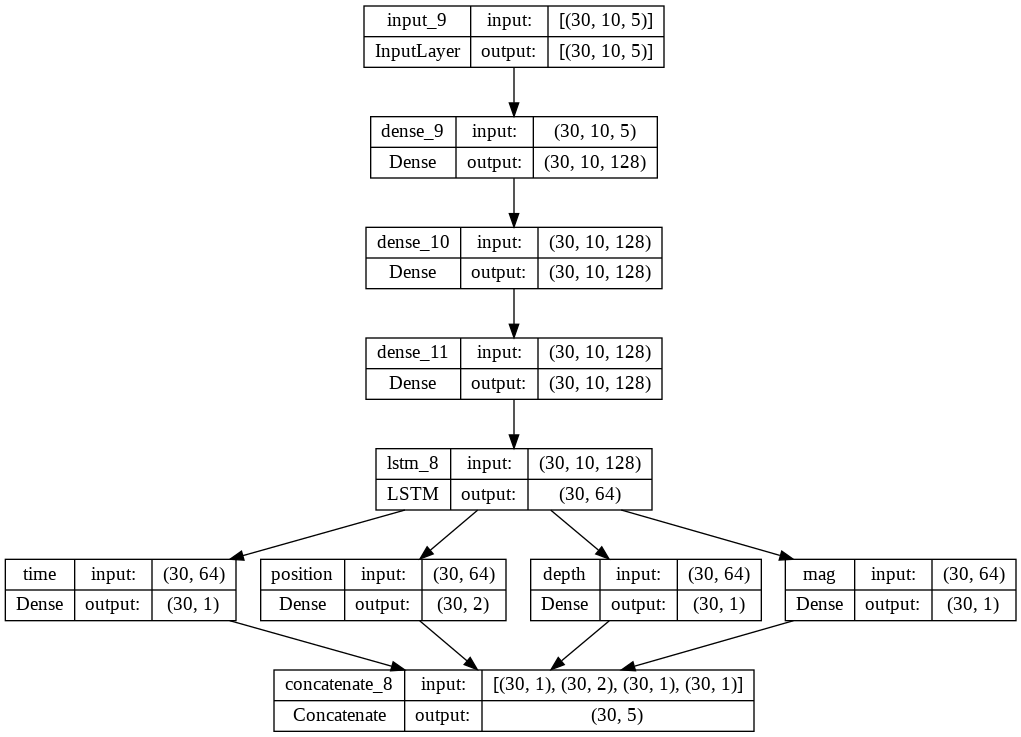

In [663]:
plot_model(model, to_file='model_shapes.png', show_shapes=True)

# 손실 함수 정의

In [411]:
def degrees_to_radians(deg):
    return tf.convert_to_tensor(np.pi,dtype=tf.float32)*deg/180

def sphericalToOrthogonal(lat,lon):
  x = tf.math.cos(lat)*tf.math.cos(lon)
  y = tf.math.cos(lat)*tf.math.sin(lon)
  z = tf.math.sin(lat)

  return tf.transpose(tf.stack([x,y,z]))

In [578]:
def haversine_distance_loss(lat1,lon1,lat2,lon2):
    
    # 위도와 경도의 단위를 라디안으로 변환
    lat1 = degrees_to_radians(lat1*90)
    lon1 = degrees_to_radians(lon1*180)
    lat2 = degrees_to_radians(lat2*90)
    lon2 = degrees_to_radians(lon2*180)

    p_1 = sphericalToOrthogonal(lat1,lon1)
    p_2 = sphericalToOrthogonal(lat2,lon2)
    

    # 유클리드 거리 공식 사용
    ThreeDimensionalDistance = tf.math.reduce_euclidean_norm(p_1-p_2,1)
     
    # 거리의 제곱을 반환
    return (2*tf.math.asin(ThreeDimensionalDistance/2))**2#/(np.pi**2)


In [646]:
c_0 = tf.constant([[1, 0], [-1, 1], [-1, 0], [-1, 0]],dtype=tf.float32)
c_1 = tf.constant([[0.6, -0.8], [-0.1, 0], [-0.5, 0], [-1, 0]],dtype=tf.float32)
c_1

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[ 0.6, -0.8],
       [-0.1,  0. ],
       [-0.5,  0. ],
       [-1. ,  0. ]], dtype=float32)>

In [647]:
haversine_distance_loss(c_0[:,0],c_0[:,1],c_1[:,0],c_1[:,1])

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.39478397, 1.9985949 , 0.6168504 , 0.        ], dtype=float32)>

In [614]:
def custom_loss_function(y_true, y_pred):
    # 위도와 경도는 지구 위의 2개의 점 사이의 거리를 측정하는 커스텀 손실 함수

    distance_loss = 10*haversine_distance_loss(y_true[:,1], y_true[:, 2], y_pred[:, 1], y_pred[:, 2])
    # 나머지 파라미터는 평균 제곱 오차를 측정하는 함수
    true_time, true_depth, true_mag = y_true[:, 0], y_true[:, 3], y_true[:, 4]
    pred_time, pred_depth, pred_mag = y_pred[:, 0], y_pred[:, 3], y_pred[:, 4]
    
    # Calculate the mean squared error loss for the time, depth, and mag dimensions
    mse_loss = (true_time - pred_time)**2 + (true_depth - pred_depth)**2 + 10**((true_mag - pred_mag)**2)
    # mse_loss = losses.mean_squared_error(tf.gather(y_true, [0, 3, 4], axis=1), tf.gather(y_pred, [0, 3, 4], axis=1))
    # 커스텀 손실 함수 결과 반환
    return tf.reduce_mean(distance_loss + mse_loss)


# 콜백 함수 정의

In [615]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
        self.losses = []
        self.accuracys = []
        # self.term.__init__()
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracys.append(logs.get('acc'))

In [616]:
history = LossHistory() # 손실 이력 객체 생성

# history.init()

In [617]:
term = TerminateOnNaN()

In [618]:
log_dir = "logs/my_board/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# 모델 컴파일

In [665]:
with tf.device('/device:GPU:0'):
  model.compile(loss=custom_loss_function, optimizer="adam")#tf.keras.optimizers.Adam(learning_rate=0.0001)

# 모델 훈련

In [666]:
with tf.device('/device:GPU:0'):
  
  X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
  y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

  for epoch_idx in range(num_epochs):
      print ('epochs : ' + str(epoch_idx) )
      model.fit(X_train_tensor, y_train_tensor, epochs=1, batch_size=batch_size, verbose=2, shuffle=False, callbacks=[history,tensorboard_callback]) #term
      model.reset_states()
    

epochs : 0
233/233 - 5s - loss: 17.8250 - 5s/epoch - 21ms/step
epochs : 1
233/233 - 3s - loss: 16.2271 - 3s/epoch - 11ms/step
epochs : 2
233/233 - 3s - loss: 16.1603 - 3s/epoch - 11ms/step
epochs : 3
233/233 - 3s - loss: 16.1243 - 3s/epoch - 11ms/step
epochs : 4
233/233 - 3s - loss: 16.0966 - 3s/epoch - 11ms/step
epochs : 5
233/233 - 3s - loss: 16.0758 - 3s/epoch - 11ms/step
epochs : 6
233/233 - 3s - loss: 16.0524 - 3s/epoch - 11ms/step
epochs : 7
233/233 - 3s - loss: 16.0232 - 3s/epoch - 11ms/step
epochs : 8
233/233 - 3s - loss: 15.9961 - 3s/epoch - 11ms/step
epochs : 9
233/233 - 3s - loss: 15.9688 - 3s/epoch - 11ms/step


# 훈련 결과

In [667]:
#%tensorboard --logdir {log_dir}

In [668]:
#weights = model.get_weights()
#weights

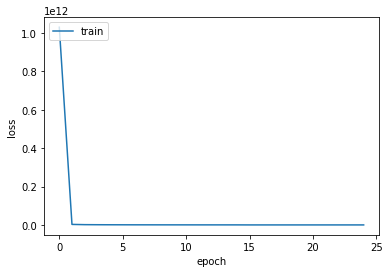

In [671]:
# 6. 학습과정 살펴보기
%matplotlib inline

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [670]:
# 7. 모델 평가하기
X_test_tensor = tf.convert_to_tensor(X_test[test_start_steps:test_start_steps+40*batch_size,:,:5], dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test[test_start_steps:test_start_steps+40*batch_size,:], dtype=tf.float32)
scores = model.evaluate(X_test_tensor, y_test_tensor, batch_size=batch_size)
print("%s: %.2f" %(model.metrics_names[0], scores))
model.reset_states()

40/40 [==============================] - 1s 6ms/step - loss: 15.7599
loss: 15.76


# 모델 예상

In [672]:
X_test_time = X_test[test_start_steps:test_end_steps,:,5]
X_test_time[:3]

array([[Timestamp('2010-05-06 02:42:47.940000+0000', tz='UTC'),
        Timestamp('2010-05-09 05:59:41.620000+0000', tz='UTC'),
        Timestamp('2010-05-19 04:15:43.230000+0000', tz='UTC'),
        Timestamp('2010-05-19 10:30:10.400000+0000', tz='UTC'),
        Timestamp('2010-05-19 10:51:03.080000+0000', tz='UTC'),
        Timestamp('2010-05-23 22:46:52.050000+0000', tz='UTC'),
        Timestamp('2010-05-24 16:18:29.090000+0000', tz='UTC'),
        Timestamp('2010-05-25 10:09:05.780000+0000', tz='UTC'),
        Timestamp('2010-05-26 08:53:08.030000+0000', tz='UTC'),
        Timestamp('2010-05-27 17:14:46.570000+0000', tz='UTC')],
       [Timestamp('2010-05-09 05:59:41.620000+0000', tz='UTC'),
        Timestamp('2010-05-19 04:15:43.230000+0000', tz='UTC'),
        Timestamp('2010-05-19 10:30:10.400000+0000', tz='UTC'),
        Timestamp('2010-05-19 10:51:03.080000+0000', tz='UTC'),
        Timestamp('2010-05-23 22:46:52.050000+0000', tz='UTC'),
        Timestamp('2010-05-24 16:18:29.

In [673]:
X_test.shape

(5813, 10, 6)

In [674]:
X_test[test_start_steps:test_end_steps,:,:5].shape

(329, 10, 5)

In [675]:
X_to_test = X_test[test_start_steps:test_end_steps,:,:5]
X_to_test[:3]

array([[[0.003125, -0.20064444444444443, -0.39192777777777776,
         0.05377906976744186, 0.0571428571428572],
        [0.009375, 0.04164444444444445, 0.5334333333333333,
         0.055232558139534885, 0.3428571428571429],
        [0.03125, -0.05647777777777778, -0.4307833333333333,
         0.19186046511627908, 0.0],
        [0.0, -0.6088888888888888, -0.7514000000000001,
         0.014534883720930232, 0.0],
        [0.0, -0.6093666666666667, -0.752211111111111,
         0.014534883720930232, 0.0],
        [0.0125, -0.15475555555555556, -0.4130666666666667,
         0.14738372093023255, 0.02857142857142847],
        [0.003125, -0.08985555555555555, -0.3975444444444445,
         0.8447674418604652, 0.14285714285714285],
        [0.003125, 0.3926222222222222, -0.19957777777777777,
         0.014534883720930232, 0.08571428571428566],
        [0.003125, 0.28636666666666666, 0.7219111111111111,
         0.014534883720930232, 0.14285714285714285],
        [0.003125, -0.1522, 0.9257944444

In [676]:
y_to_test = y_test[test_start_steps+batch_size-1:test_end_steps,:]
y_to_test = tf.cast(y_to_test, tf.float32)
y_to_test[:3]

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[0.        , 0.07528889, 0.6847722 , 0.93110466, 0.42857143],
       [0.003125  , 0.06908889, 0.68621665, 0.80377907, 0.17142858],
       [0.015625  , 0.07275555, 0.6845667 , 0.8982558 , 0.17142858]],
      dtype=float32)>

In [677]:
X_to_test[0].reshape(1,timesteps,5)

array([[[0.003125, -0.20064444444444443, -0.39192777777777776,
         0.05377906976744186, 0.0571428571428572],
        [0.009375, 0.04164444444444445, 0.5334333333333333,
         0.055232558139534885, 0.3428571428571429],
        [0.03125, -0.05647777777777778, -0.4307833333333333,
         0.19186046511627908, 0.0],
        [0.0, -0.6088888888888888, -0.7514000000000001,
         0.014534883720930232, 0.0],
        [0.0, -0.6093666666666667, -0.752211111111111,
         0.014534883720930232, 0.0],
        [0.0125, -0.15475555555555556, -0.4130666666666667,
         0.14738372093023255, 0.02857142857142847],
        [0.003125, -0.08985555555555555, -0.3975444444444445,
         0.8447674418604652, 0.14285714285714285],
        [0.003125, 0.3926222222222222, -0.19957777777777777,
         0.014534883720930232, 0.08571428571428566],
        [0.003125, 0.28636666666666666, 0.7219111111111111,
         0.014534883720930232, 0.14285714285714285],
        [0.003125, -0.1522, 0.9257944444

In [678]:
model.predict(tf.convert_to_tensor(X_to_test[0:0+batch_size].reshape(batch_size,timesteps,5), dtype="float32"),verbose=0)[-1,:].shape

(5,)

In [679]:
y_pred = np.array([])
for i in range(test_steps):
  y_pred = np.append(y_pred,model.predict(tf.convert_to_tensor(X_to_test[i:i+batch_size].reshape(batch_size,timesteps,5), dtype="float32"),verbose=0)[-1,:])
  if i%10 == 0:
    print(i)
y_pred = tf.reshape(tf.convert_to_tensor(y_pred, dtype=tf.float32),[test_steps,5])
y_pred[:3]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[0.01592084, 1.9401644 , 1.9336516 , 0.07400635, 0.11830653],
       [0.01580771, 1.9206388 , 1.9469812 , 0.07285666, 0.12601058],
       [0.01665847, 1.8919863 , 1.9565898 , 0.074106  , 0.12438688]],
      dtype=float32)>

In [680]:
y_pred.shape

TensorShape([300, 5])

In [681]:
y_to_test.shape

TensorShape([300, 5])

In [682]:
custom_loss_function(y_to_test,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=11.780217>

In [683]:
X_test_time.shape

(329, 10)

In [684]:
y_error = []
for i in range(test_steps):
   y_error.append(custom_loss_function(tf.reshape(y_to_test[i,:],[1,5]),tf.reshape(y_pred[i,:],[1,5])))
y_error[:3]

[<tf.Tensor: shape=(), dtype=float32, numpy=8.029649>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.15659>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.860584>]

# 원래 데이터 포맷으로 돌리기

In [685]:
def reformTensorToEarthQuake(y_pred,inverse_transform=True):
    y_pred = pd.DataFrame(y_pred.numpy(),index=range(test_steps),columns = data.columns[:5])
    if inverse_transform:
        for column in data.columns[0:5]:
            y_pred.loc[:,[column]] = pipe.named_transformers_[column].inverse_transform(y_pred.loc[:,[column]])
    y_pred["time"] = X_test_time[batch_size-1:,-1].astype("datetime64[D]") + tf.math.round(y_pred["time"]).numpy().astype('timedelta64[D]')
    y_pred = y_pred.iloc[::-1]
    y_pred['time'] = y_pred['time'].astype(str)
    return y_pred

In [686]:
y_to_test = reformTensorToEarthQuake(y_to_test)

<ipython-input-685-cf5a58fd6a01>:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  y_pred["time"] = X_test_time[batch_size-1:,-1].astype("datetime64[D]") + tf.math.round(y_pred["time"]).numpy().astype('timedelta64[D]')


In [687]:
y_pred = reformTensorToEarthQuake(y_pred)

<ipython-input-685-cf5a58fd6a01>:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  y_pred["time"] = X_test_time[batch_size-1:,-1].astype("datetime64[D]") + tf.math.round(y_pred["time"]).numpy().astype('timedelta64[D]')


In [688]:
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 299 to 0
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       300 non-null    object 
 1   latitude   300 non-null    float32
 2   longitude  300 non-null    float32
 3   depth      300 non-null    float32
 4   mag        300 non-null    float32
dtypes: float32(4), object(1)
memory usage: 7.2+ KB


In [689]:
y_to_test

,time,latitude,longitude,depth,mag
299,2012-04-11,2.327000,93.062996,20.000000,8.6
298,2012-04-06,-4.551000,153.457001,108.500000,6.1
297,2012-04-02,16.395000,-98.315994,9.000000,6.0
296,2012-03-27,39.859001,142.016998,14.999999,6.1
295,2012-03-26,10.071000,-104.160004,10.000000,6.0
...,...,...,...,...,...
4,2010-08-03,1.239000,126.212997,41.000000,6.3
3,2010-07-30,52.498001,159.843002,23.000000,6.3
2,2010-07-29,6.548000,123.222000,618.000000,6.6
1,2010-07-24,6.218000,123.518997,553.000000,6.6


In [690]:
y_pred

,time,latitude,longitude,depth,mag
299,2012-04-12,173.985825,344.501984,56.436779,6.389457
298,2012-04-08,167.295624,354.917755,56.386341,6.355723
297,2012-04-02,165.423004,350.093750,55.751175,6.405227
296,2012-04-01,171.485840,360.811005,55.747669,6.430003
295,2012-03-30,187.820892,352.367798,52.298523,6.463065
...,...,...,...,...,...
4,2010-08-05,161.841705,342.490662,53.592743,6.340158
3,2010-08-03,169.878204,351.803741,51.183628,6.422991
2,2010-07-29,170.278763,352.186157,50.984928,6.435354
1,2010-07-28,172.857498,350.456604,50.125381,6.441037


# 데이터 시각화

In [571]:
def adjustLatitude(lat):
  latitude = lat
  if latitude > 90:
      latitude = 180 - latitude
  elif latitude < -90:
      latitude = - 180 - latitude
  return float(latitude)

def adjustLongitude(lon):
  longitude = lon
  longitude %= 360
  return float(longitude)

In [572]:
def toString(_float):
  return str(round(_float, 2))

In [573]:
def AddLine(realData,predData,array):
  for i, row in realData.iterrows():
    realLatitude = adjustLatitude(row['latitude'])
    realLongitude = adjustLongitude(row['longitude'])
    earlyTime = row['time']
    if(row['time']>predData.loc[i,'time']): 
      earlyTime = predData.loc[i,'time']
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'LineString',
            'coordinates': [[realLongitude,realLatitude],[adjustLongitude(predData.loc[i,'longitude']),adjustLatitude(predData.loc[i,'latitude'])]]
        },
        'properties': {
            'times': [row['time'],predData.loc[i,'time']],
            'style': {'radius': 0.1},
            'icon': 'circle'
        }
    }
    array.append(feature)
  return array

In [574]:
def AddCircles(data,colormap,array):
  surfaceEnergy = np.multiply(10**(data['mag']*1.5),1/(data['depth']**2+1))
  minSurfaceEnergy = surfaceEnergy.min()

  for i, row in data.iterrows():
      borderRadius = np.power(10**(row['mag']*1.5)/minSurfaceEnergy - row['depth']**2,1/6)
      # np.sqrt(10**(row['mag']*1.5)/minSurfaceEnergy - row['depth']**2)
      color = colormap(row['mag'])
      latitude = adjustLatitude(row['latitude'])
      longitude = adjustLongitude(row['longitude'])
      feature = {
          'type': 'Feature',
          'geometry': {
              'type': 'Point',
              'coordinates': [longitude, latitude]
          },
          'properties': {
              'time': row['time'],
              'style': {'color': color, 'radius': borderRadius},
              "popup": "date: "+row['time']+"<br>longitude: "+toString(longitude)+"<br>latitude: "+toString(latitude)+"<br>magnitude: "+toString(row['mag'])+"<br>depth: "+toString(row['depth'])+"km",
              'icon': 'circle'
          }
      }
      array.append(feature)
      if longitude < 180 :
        feature = {
          'type': 'Feature',
          'geometry': {
              'type': 'Point',
              'coordinates': [longitude-360, latitude]
          },
          'properties': {
              'time': row['time'],
              'style': {'color': color, 'radius': borderRadius},
              "popup": "date: "+row['time']+"<br>longitude: "+toString(longitude)+"<br>latitude: "+toString(latitude)+"<br>magnitude: "+toString(row['mag'])+"<br>depth: "+toString(row['depth'])+"km",
              'icon': 'circle'
          }
      }
      array.append(feature)
  return array

In [575]:
def earthquakeVisualizer(realData,predData):
  

  m = folium.Map(location=[0, 90], zoom_start=2)

  realColormap = folium.LinearColormap(
      ['yellow', 'red','black'],
      vmin=realData['mag'].min(), vmax=realData['mag'].max()
  )
  m.add_child(realColormap)
  predColormap = folium.LinearColormap(
      ['green', 'blue','purple'],
      vmin=predData['mag'].min(), vmax=predData['mag'].max()
  )
  m.add_child(predColormap)

  # 지도 위에 시간 인터렉티브한 바 추가
  timestamps = data['time'].unique()
  features = []
  # minEnergy = 10**(data['mag'].min()*1.5)
  # distanceOfDeepestSixMagReachToOneKM = np.sqrt(data['depth'].max()**2+1)
  features = AddCircles(realData,realColormap,features)
  features = AddCircles(predData,predColormap,features)
  features = AddLine(realData,predData,features)

  time_slider = plugins.TimestampedGeoJson({
      'type': 'FeatureCollection',
      'features': features
  }, period='P1D',duration="P1M", add_last_point=True, auto_play=False, loop=False)#

  m.add_child(time_slider)

  return m

In [691]:
m = earthquakeVisualizer(y_to_test,y_pred)
# m.save(save_directory+file_name+'.html')
m

In [577]:
# earthquakeVisualizer(data)

# 모델 저장 및 불러오기

In [ ]:
# Save the weights
model.save_weights('./checkpoints/'+file_name)

In [ ]:
# Restore the weights
# model.load_weights('./checkpoints/'+file_name)
model.load_weights('./checkpoints/EarthQuakePrediction_epoch_360_batch_size_1_trainFrom_1000_until_5000')

In [ ]:
!pwd